# Provando ad implementare il codice di un articolo

- [Ispirazione](https://paperswithcode.com/paper/deep-learning-for-ecg-segmentation)
- [Paper](https://arxiv.org/pdf/2001.04689.pdf)
- [Dataset](https://physionet.org/content/ludb/1.0.1)

A dir la verità non sono sicuro che il db sia quello giusto. 
Nel paper parlano di 455 ecg a 12 derivazioni, ma in quello che ho scaricato ce ne sono 200

In [1]:
# first of all install necessary packages
%pip install -U wfdb
%matplotlib inline

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\scalamat\AppData\Local\Programs\Python\Python38\python.exe -m pip install --upgrade pip' command.


In [2]:
# then import necessary packages
import wfdb

import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt

from keras.models import Model, load_model
from keras.layers import Input, Conv1DTranspose, BatchNormalization
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import MaxPooling1D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

### Explore some data

In [3]:
# since the paper handles 12 lead ECG data, i will use 12 leads
LEADS = ['avf', 'avl', 'avr', 'i', 'ii', 'iii', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6']
DATA_FOLDER = "./lobachevsky-university-electrocardiography-database-1.0.1/data"
SEGMENT_TO_COLOR = {
    'N': 'blue',
    't': 'green',
    'p': 'red'
}

In [4]:
from typing import Union,List, Tuple

# get signal with wfdb library
# using an index
def get_signal(index:int, as_p_signal:bool=True) -> Union[wfdb.Record, np.ndarray]:
    record = wfdb.rdrecord(DATA_FOLDER + "/" +  str(index))
    assert type(record) is wfdb.Record

    if as_p_signal:
        assert type(record.p_signal) is np.ndarray
        return record.p_signal
        
    return record

# get annotations given the ecg lead
def get_annotations(index:int, lead, as_sample=True) -> Union[wfdb.Annotation, np.ndarray]:
    annotations = wfdb.rdann(DATA_FOLDER +"/" + str(index), extension = lead)
    if as_sample:
        return np.array(annotations.sample)
    return annotations

# get a full EGC with 12 leads
def get_full_ecg(index:int):
    signal = get_signal(index)
    annotations = [
        get_annotations(index, lead) for lead in LEADS
    ]
    return signal, annotations


def get_single_lead_ecg(index, lead) -> Tuple[np.ndarray, np.ndarray]:
    """
    return and ecg signal and its annotations
    both as ndarray
    """
    signal = get_signal(index)
    assert type(signal) is np.ndarray
    signal = signal[:, LEADS.index(lead)]

    samples = get_annotations(index, lead)
    assert type(samples) is np.ndarray
    
    return signal, samples


def get_annotations_symbols(index, lead):
    ann = get_annotations(index, lead, as_sample=False)
    return ann.symbol

def paired_annotation_sample_and_symbol(index, lead):
    annotations_symbols = get_annotations_symbols(index, lead)
    annotations_sample = get_annotations(index, lead)
    return zip(annotations_sample, annotations_symbols)


def get_single_lead_ecg_with_symbols(index, lead):
    """
    return and ecg signal and its annotations
    both as ndarray
    """
    signal = get_signal(index)
    assert type(signal) is np.ndarray
    signal = signal[:, LEADS.index(lead)]

    data = paired_annotation_sample_and_symbol(index, lead)
    
    return signal, np.array(list(data))

# plot single lead ecg with annotations
def plot_single_lead_ecg(index, lead):
    signal, samples = get_single_lead_ecg(index, lead)

    fig, ax = plt.subplots(figsize = (28, 3))

    ax.plot(signal)
    ax.scatter(samples, signal[samples], c = 'r', marker = 'o')


# now plot every lead with annotations
def plot_signal_with_annotation(index):
    signal, samples = get_full_ecg(index)
    # extract sample from annotations
    wfdb.plot_items(signal, samples )


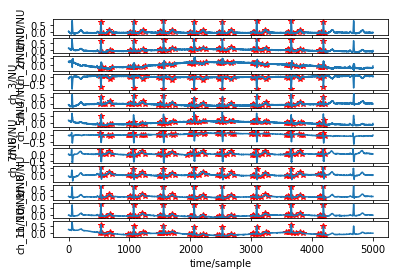

In [5]:
plot_signal_with_annotation(199)   

### Plotto anche una sola derivazione
La descrizione dell'articolo dice che gli ECG sono lunghi 10sec. Se in 10sec sono stati presi 5000 campioni, allora l'ECG andava a 500Hz.

In [6]:
def grouped(itr, n=3):
    itr = iter(itr)
    end = object()
    while True:
        vals = tuple(next(itr, end) for _ in range(n))
        if vals[-1] is end:
            return
        yield vals

array([-1, -1, -1, ..., -1, -1, -1])

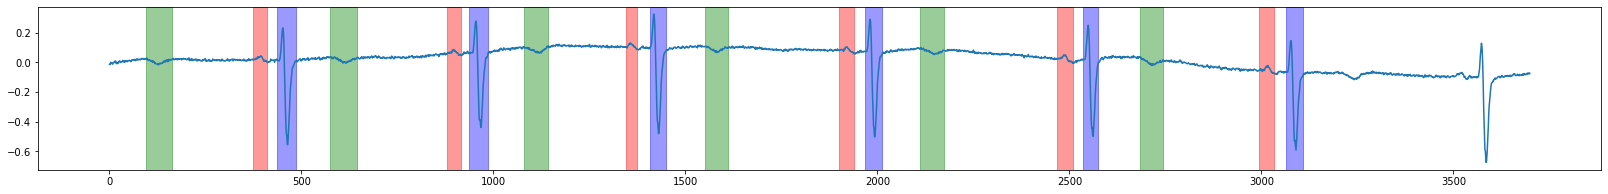

In [74]:
class EGCSignal:
    def __init__(self, signal, time_point, symbol):
        self.signal:np.ndarray = signal
        self.time_point:np.ndarray = time_point
        self.symbols:list[str] = symbol
        self.categories = self.symbols_to_category()

        self._cut_beginning(1100)
        self._cut_end(200)

    def __getitem__(self, key):
        return self.signal[key]

    def __len__(self):
        return len(self.signal)

    def _cut_beginning(self, start_point):
        self.signal = self.signal[start_point:]
        self.categories = self.categories[start_point:]

        if start_point > self.time_point[0]:
            # get the index of the first time point greater than start_point
            index = np.argmax(self.time_point > start_point)                
            self.time_point = self.time_point[index:]
            self.symbols = self.symbols[index:]
        
        self.time_point = self.time_point - start_point

    
    def _cut_end(self, end_point):
        self.signal = self.signal[:-end_point]
        self.categories = self.categories[:-end_point]

    def plot(self, ax=None):
        if ax is None:
            fig, ax = plt.subplots(figsize = (28, 3))
        ax.plot(self.signal)

    def plot_with_time_point(self):
        fig, ax = plt.subplots(figsize = (28, 3))
        self.plot(ax)
        ax.scatter(self.time_point, self.signal[self.time_point], c = 'r', marker = 'o')

    def plot_with_segments(self):
        fig, ax = plt.subplots(figsize = (28, 3))
        self.plot(ax)

        for start, symbol, end in grouped(self.time_point, 3):
            i = np.nonzero(self.time_point == symbol)[0][0]
            current_symbol = self.symbols[i]
            color = SEGMENT_TO_COLOR[current_symbol]
            ax.axvspan(start, end, color=color, alpha=0.4)

    def symbols_to_category(self):
        """
        converts the symbols list in a numpy array of integers
        same length as the signal
        """

        symbol_to_category = {
            'N': 0,
            't': 1,
            'p': 2
        }
            
        # first instantiate an array of -1 same length as the signal
        category = np.full(len(self.signal), -1)
        # now fill the array with the known category
        for section in grouped(self.time_point):
            # unpack the section
            start, peak, end = section
            
            # get the category given the peak
            i = np.nonzero(self.time_point == peak)[0][0]
            current_symbol = self.symbols[i]            
            category[start:end] = symbol_to_category[current_symbol]

        return category


    @staticmethod
    def from_index_and_lead(index, lead):
        return EGCSignal(
        get_signal(index)[:, LEADS.index(lead)],
        get_annotations(index, lead),
        get_annotations_symbols(index, lead)
    )

# plot
EGCSignal.from_index_and_lead(199, 'v1').plot_with_segments()

EGCSignal.from_index_and_lead(199, 'v1').symbols_to_category()


In [64]:
ecg =  EGCSignal.from_index_and_lead(199, 'v1')
point_color = ecg.symbols_to_category()

point_color


KeyError: ')'

### Incomincio a preparare X e Y per la rete
siccome mi sono un po scomodi i dati, mi faccio un classe per rappresenatare tutto

In [42]:
SEGMENT_TO_COLOR

{'N': 'blue', 't': 'green', 'p': 'red'}

In [71]:
lista = list("0123456")
lista[2:]

['2', '3', '4', '5', '6']